In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# LSTM Multivariate
Using lookback = 1

## Load and prepare the data

In [2]:
df = pd.read_csv('../cleaned_data/TLKM.csv', index_col='Date', parse_dates=True)
df.head()

,7 DAYS MA,14 DAYS MA,21 DAYS MA,7 DAYS STD DEV,RSI 7,RSI 14,RSI 21,MFI 7,MFI 14,MFI 21,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Close
Date,,,,,,,,,,,,,,,,,,
2012-10-17,-1.901334,-1.927720,-1.944208,-1.101544,0.683641,0.956443,1.268434,1.023638,1.496048,1.474483,0.008923,1.34241,1.016593,-1.845348,1.033444,0.147246,1.030312,-1.884821
2012-10-18,-1.895749,-1.920264,-1.939855,-1.125565,0.002534,0.390498,0.764540,0.097491,0.901053,0.930980,0.716706,1.34241,1.016593,-1.845348,1.042927,0.261864,1.030312,-1.910838
2012-10-19,-1.895749,-1.916537,-1.936745,-1.125565,0.002534,0.390498,0.764540,0.479965,1.377288,1.339236,1.424489,1.34241,1.016593,-1.845348,1.052410,0.376483,1.030312,-1.910838
2012-10-22,-1.895749,-1.911877,-1.933636,-1.125565,-0.640938,-0.151083,0.278258,-0.448894,0.849284,0.941209,-1.406643,1.34241,1.016593,-1.845348,1.080859,0.720337,1.096678,-1.936855
2012-10-23,-1.903195,-1.910945,-1.931770,-1.049270,0.052614,0.327538,0.664071,-0.448894,0.621549,1.174465,-0.698860,1.34241,1.016593,-1.845348,1.090342,0.834955,1.096678,-1.910838


### Split the dataset into train and test

In [3]:
train_len = int(len(df)*.8)
train_dataset = df[:train_len]
test_dataset = df[train_len:len(df)]

In [4]:
train_y = train_dataset[['Close']]

### Create the train dataset

In [5]:
hops = 1
train_len = len(train_dataset)

X_train = []
y_train = []

for i in range(hops, train_len):
    X_train.append(train_dataset[i-hops:i])
    y_train.append(train_y.iloc[i][0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

In [6]:
X_train.shape

(1966, 1, 18)

In [7]:
y_train.shape

(1966,)

**Reshape the X_train into 3d**
Required for LSTM

In [8]:
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_train_reshaped.shape

(1966, 1, 18)

### Create the test dataset

In [9]:
train_dataset_last_hops = train_dataset.iloc[-1*hops:]
test_dataset_full = test_dataset.copy()
test_dataset_full = pd.concat((train_dataset_last_hops, test_dataset_full), axis=0)

In [10]:
test_dataset_full_y = test_dataset_full[['Close']]

In [11]:
test_len = test_dataset_full.shape[0]

X_test = []
y_test = []

for i in range(hops, test_len):
    X_test.append(test_dataset_full[i-hops:i])
    y_test.append(test_dataset_full_y.iloc[i][0])
    
X_test, y_test = np.array(X_test), np.array(y_test)

In [12]:
X_test.shape

(492, 1, 18)

## Modeling with LSTM

In [13]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [14]:
def build_model(lstm_unit1, lstm_unit2, hops):
    """
    Function to build LSTM model architecture
    """
    model = Sequential()
    model.add(LSTM(units=lstm_unit1, return_sequences=True, input_shape=(hops,18)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=lstm_unit2))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    print(model.summary())
    return model

In [15]:
def fit_model(model, X_train, y_train, epochs, batch_size):
    """
    Function to fit the model with specified epochs and batch size
    """
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)
    return history

In [16]:
def predict(model, X_test):
    predictions = model.predict(X_test)
    actual_close = df[['Close']]
    actual_close = pd.DataFrame(actual_close.iloc[train_len:, 0])
    predictions = pd.DataFrame(predictions)
    predictions.reset_index(drop=True, inplace=True)
    predictions.index = test_dataset.index
    predictions['Actual'] = actual_close['Close']
    predictions.rename(columns={0:'Pred'}, inplace=True)
    return predictions

In [17]:
def plot_pred_act(predictions_df):
    """
    Function to plot and compare y_true and y_pred
    """
    plt.title('True vs Predicted')
    predictions_df['Actual'].plot(figsize=(20,8), legend=True, color='blue')
    predictions_df['Pred'].plot(legend=True, color='red', figsize=(20,8))
    plt.legend(loc='best')
    plt.xlabel('Standardized Close Price')
    plt.show()

In [18]:
from joblib import load

close_scaler = load('../feature_engineering/tlkm_close_scaler.bin')

In [19]:
def inverse_pred_act(predictions_df):
    """
    Function to inverse standardized Close value
    """
    inversed_pred = close_scaler.inverse_transform(np.array(predictions_df['Pred']).reshape(-1,1))
    inversed_act = close_scaler.inverse_transform(np.array(predictions_df['Actual']).reshape(-1,1))
    inversed = pd.DataFrame(inversed_pred)
    inversed['Actual'] = inversed_act
    inversed.rename({0:'Pred'}, axis=1, inplace=True)
    inversed.index = test_dataset.index
    return inversed

In [32]:
def plotErrorHist(inversed_df):
    """
    Function to plot error histogram
    """
    error = inversed_df['Pred'] - inversed_df['Actual']
    # plt.hist(error, bins=25)
    plt.figure(figsize=(15,12))
    sns.displot(error)
    plt.xlabel('Prediction Error [Close]')
    _ = plt.ylabel('Count')

In [21]:
"""
Evaluation metrics
"""
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import r2_score

def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [22]:
def evaluate(inversed_df):
    """
    Function to evaluate predictions
    """
    rmse_ = rmse(inversed_df['Actual'], inversed_df['Pred'])
    mape_ = mape(inversed_df['Actual'], inversed_df['Pred'])
    r2 = r2_score(inversed_df['Actual'], inversed_df['Pred'])
    return rmse_, mape_, r2

In [23]:
epochs_candidates = [100,150,200]
batch_size_candidates = [16,32,64]
lstm_unit1_candidates = [50, 100]
lstm_unit2_candidates = [50, 100]

In [24]:
models = {}
predictions_dfs = {}
inversed_dfs = {}
performances = {}

In [25]:
modelID = 1
for e in epochs_candidates:
    for b in batch_size_candidates:
        for l1 in lstm_unit1_candidates:
            for l2 in lstm_unit2_candidates:
                model = build_model(lstm_unit1=l1, lstm_unit2=l2, hops=1)
                history = fit_model(model, X_train, y_train, epochs=e, batch_size=b)
                models[f'Model-{modelID}'] = (model, history)
                
                predictions = predict(model, X_test)
                predictions_dfs[f'Model-{modelID}'] = predictions
                
                inversed = inverse_pred_act(predictions)
                inversed_dfs[f'Model-{modelID}'] = inversed
                rmse_, mape_, r2 = evaluate(inversed)
                
                performances[f'Model-{modelID}'] = {
                    'epochs': e,
                    'batch size': b,
                    'lstm unit 1': l1,
                    'lstm unit 2': l2,
                    'RMSE': rmse_,
                    'MAPE': mape_,
                    'r2': r2
                }
                modelID += 1

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 50)             13800     
                                                                 
 dropout (Dropout)           (None, 1, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 34,051
Trainable params: 34,051
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
123/123 [==========================

123/123 [==============================] - 1s 9ms/step - loss: 0.0155
Epoch 87/100
123/123 [==============================] - 1s 9ms/step - loss: 0.0155
Epoch 88/100
123/123 [==============================] - 1s 9ms/step - loss: 0.0147
Epoch 89/100
123/123 [==============================] - 1s 9ms/step - loss: 0.0153
Epoch 90/100
123/123 [==============================] - 1s 9ms/step - loss: 0.0152
Epoch 91/100
123/123 [==============================] - 1s 9ms/step - loss: 0.0159
Epoch 92/100
123/123 [==============================] - 1s 9ms/step - loss: 0.0157
Epoch 93/100
123/123 [==============================] - 1s 9ms/step - loss: 0.0150
Epoch 94/100
123/123 [==============================] - 1s 9ms/step - loss: 0.0151
Epoch 95/100
123/123 [==============================] - 1s 9ms/step - loss: 0.0146
Epoch 96/100
123/123 [==============================] - 1s 9ms/step - loss: 0.0158
Epoch 97/100
123/123 [==============================] - 1s 9ms/step - loss: 0.0159
Epoch 98/100
123/

123/123 [==============================] - 1s 10ms/step - loss: 0.0130
Epoch 72/100
123/123 [==============================] - 1s 9ms/step - loss: 0.0134
Epoch 73/100
123/123 [==============================] - 1s 9ms/step - loss: 0.0130
Epoch 74/100
123/123 [==============================] - 1s 9ms/step - loss: 0.0144
Epoch 75/100
123/123 [==============================] - 1s 9ms/step - loss: 0.0125
Epoch 76/100
123/123 [==============================] - 1s 9ms/step - loss: 0.0132
Epoch 77/100
123/123 [==============================] - 1s 9ms/step - loss: 0.0136
Epoch 78/100
123/123 [==============================] - 1s 9ms/step - loss: 0.0132
Epoch 79/100
123/123 [==============================] - 1s 9ms/step - loss: 0.0127
Epoch 80/100
123/123 [==============================] - 1s 9ms/step - loss: 0.0128
Epoch 81/100
123/123 [==============================] - 1s 10ms/step - loss: 0.0121
Epoch 82/100
123/123 [==============================] - 1s 10ms/step - loss: 0.0122
Epoch 83/100
1

Epoch 56/100
123/123 [==============================] - 1s 10ms/step - loss: 0.0144
Epoch 57/100
123/123 [==============================] - 1s 9ms/step - loss: 0.0149
Epoch 58/100
123/123 [==============================] - 1s 10ms/step - loss: 0.0140
Epoch 59/100
123/123 [==============================] - 1s 9ms/step - loss: 0.0145
Epoch 60/100
123/123 [==============================] - 1s 9ms/step - loss: 0.0152
Epoch 61/100
123/123 [==============================] - 1s 9ms/step - loss: 0.0148
Epoch 62/100
123/123 [==============================] - 1s 10ms/step - loss: 0.0140
Epoch 63/100
123/123 [==============================] - 1s 10ms/step - loss: 0.0140
Epoch 64/100
123/123 [==============================] - 1s 9ms/step - loss: 0.0149
Epoch 65/100
123/123 [==============================] - 1s 9ms/step - loss: 0.0149
Epoch 66/100
123/123 [==============================] - 1s 9ms/step - loss: 0.0138
Epoch 67/100
123/123 [==============================] - 1s 9ms/step - loss: 0.0141


123/123 [==============================] - 1s 10ms/step - loss: 0.0112
Epoch 41/100
123/123 [==============================] - 1s 10ms/step - loss: 0.0124
Epoch 42/100
123/123 [==============================] - 1s 10ms/step - loss: 0.0123
Epoch 43/100
123/123 [==============================] - 1s 10ms/step - loss: 0.0130
Epoch 44/100
123/123 [==============================] - 1s 10ms/step - loss: 0.0124
Epoch 45/100
123/123 [==============================] - 1s 10ms/step - loss: 0.0118
Epoch 46/100
123/123 [==============================] - 1s 10ms/step - loss: 0.0119
Epoch 47/100
123/123 [==============================] - 1s 10ms/step - loss: 0.0122
Epoch 48/100
123/123 [==============================] - 1s 10ms/step - loss: 0.0114
Epoch 49/100
123/123 [==============================] - 1s 10ms/step - loss: 0.0119
Epoch 50/100
123/123 [==============================] - 1s 10ms/step - loss: 0.0121
Epoch 51/100
123/123 [==============================] - 1s 10ms/step - loss: 0.0120
Epoch

Epoch 25/100
62/62 [==============================] - 1s 9ms/step - loss: 0.0178
Epoch 26/100
62/62 [==============================] - 1s 9ms/step - loss: 0.0177
Epoch 27/100
62/62 [==============================] - 1s 9ms/step - loss: 0.0169
Epoch 28/100
62/62 [==============================] - 1s 9ms/step - loss: 0.0178
Epoch 29/100
62/62 [==============================] - 1s 9ms/step - loss: 0.0171
Epoch 30/100
62/62 [==============================] - 1s 9ms/step - loss: 0.0174
Epoch 31/100
62/62 [==============================] - 1s 9ms/step - loss: 0.0182
Epoch 32/100
62/62 [==============================] - 1s 9ms/step - loss: 0.0177
Epoch 33/100
62/62 [==============================] - 1s 9ms/step - loss: 0.0179
Epoch 34/100
62/62 [==============================] - 1s 9ms/step - loss: 0.0180
Epoch 35/100
62/62 [==============================] - 1s 9ms/step - loss: 0.0177
Epoch 36/100
62/62 [==============================] - 1s 9ms/step - loss: 0.0185
Epoch 37/100
62/62 [========

Epoch 12/100
62/62 [==============================] - 1s 10ms/step - loss: 0.0170
Epoch 13/100
62/62 [==============================] - 1s 10ms/step - loss: 0.0172
Epoch 14/100
62/62 [==============================] - 1s 10ms/step - loss: 0.0179
Epoch 15/100
62/62 [==============================] - 1s 10ms/step - loss: 0.0160
Epoch 16/100
62/62 [==============================] - 1s 10ms/step - loss: 0.0162
Epoch 17/100
62/62 [==============================] - 1s 10ms/step - loss: 0.0163
Epoch 18/100
62/62 [==============================] - 1s 10ms/step - loss: 0.0162
Epoch 19/100
62/62 [==============================] - 1s 10ms/step - loss: 0.0155
Epoch 20/100
62/62 [==============================] - 1s 10ms/step - loss: 0.0152
Epoch 21/100
62/62 [==============================] - 1s 10ms/step - loss: 0.0156
Epoch 22/100
62/62 [==============================] - 1s 10ms/step - loss: 0.0165
Epoch 23/100
62/62 [==============================] - 1s 10ms/step - loss: 0.0149
Epoch 24/100
62/

Total params: 77,851
Trainable params: 77,851
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
62/62 [==============================] - 14s 11ms/step - loss: 0.4486
Epoch 2/100
62/62 [==============================] - 1s 10ms/step - loss: 0.0284
Epoch 3/100
62/62 [==============================] - 1s 10ms/step - loss: 0.0227
Epoch 4/100
62/62 [==============================] - 1s 10ms/step - loss: 0.0210
Epoch 5/100
62/62 [==============================] - 1s 10ms/step - loss: 0.0186
Epoch 6/100
62/62 [==============================] - 1s 10ms/step - loss: 0.0186
Epoch 7/100
62/62 [==============================] - 1s 10ms/step - loss: 0.0185
Epoch 8/100
62/62 [==============================] - 1s 10ms/step - loss: 0.0181
Epoch 9/100
62/62 [==============================] - 1s 10ms/step - loss: 0.0165
Epoch 10/100
62/62 [==============================] - 1s 10ms/step - loss: 0.0171
Epoch 11/100
62/62 [===========================

62/62 [==============================] - 1s 10ms/step - loss: 0.0134
Epoch 99/100
62/62 [==============================] - 1s 10ms/step - loss: 0.0139
Epoch 100/100
16/16 [==============================] - 3s 5ms/step
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 1, 100)            47600     
                                                                 
 dropout_14 (Dropout)        (None, 1, 100)            0         
                                                                 
 lstm_15 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_15 (Dropout)        (None, 100)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                  

62/62 [==============================] - 1s 11ms/step - loss: 0.0117
Epoch 85/100
62/62 [==============================] - 1s 11ms/step - loss: 0.0109
Epoch 86/100
62/62 [==============================] - 1s 11ms/step - loss: 0.0118
Epoch 87/100
62/62 [==============================] - 1s 11ms/step - loss: 0.0112
Epoch 88/100
62/62 [==============================] - 1s 11ms/step - loss: 0.0114
Epoch 89/100
62/62 [==============================] - 1s 11ms/step - loss: 0.0115
Epoch 90/100
62/62 [==============================] - 1s 11ms/step - loss: 0.0117
Epoch 91/100
62/62 [==============================] - 1s 11ms/step - loss: 0.0116
Epoch 92/100
62/62 [==============================] - 1s 11ms/step - loss: 0.0104
Epoch 93/100
62/62 [==============================] - 1s 11ms/step - loss: 0.0108
Epoch 94/100
62/62 [==============================] - 1s 11ms/step - loss: 0.0114
Epoch 95/100
62/62 [==============================] - 1s 11ms/step - loss: 0.0112
Epoch 96/100
62/62 [=========

31/31 [==============================] - 0s 10ms/step - loss: 0.0162
Epoch 71/100
31/31 [==============================] - 0s 11ms/step - loss: 0.0165
Epoch 72/100
31/31 [==============================] - 0s 11ms/step - loss: 0.0162
Epoch 73/100
31/31 [==============================] - 0s 11ms/step - loss: 0.0154
Epoch 74/100
31/31 [==============================] - 0s 10ms/step - loss: 0.0170
Epoch 75/100
31/31 [==============================] - 0s 10ms/step - loss: 0.0157
Epoch 76/100
31/31 [==============================] - 0s 10ms/step - loss: 0.0164
Epoch 77/100
31/31 [==============================] - 0s 11ms/step - loss: 0.0163
Epoch 78/100
31/31 [==============================] - 0s 10ms/step - loss: 0.0165
Epoch 79/100
31/31 [==============================] - 0s 10ms/step - loss: 0.0162
Epoch 80/100
31/31 [==============================] - 0s 10ms/step - loss: 0.0166
Epoch 81/100
31/31 [==============================] - 0s 10ms/step - loss: 0.0160
Epoch 82/100
31/31 [=========

31/31 [==============================] - 0s 12ms/step - loss: 0.0138
Epoch 57/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0134
Epoch 58/100
31/31 [==============================] - 0s 11ms/step - loss: 0.0149
Epoch 59/100
31/31 [==============================] - 0s 11ms/step - loss: 0.0136
Epoch 60/100
31/31 [==============================] - 0s 14ms/step - loss: 0.0134
Epoch 61/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0141
Epoch 62/100
31/31 [==============================] - 0s 11ms/step - loss: 0.0146
Epoch 63/100
31/31 [==============================] - 0s 11ms/step - loss: 0.0140
Epoch 64/100
31/31 [==============================] - 0s 11ms/step - loss: 0.0140
Epoch 65/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0140
Epoch 66/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0147
Epoch 67/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0138
Epoch 68/100
31/31 [=========

31/31 [==============================] - 0s 12ms/step - loss: 0.0147
Epoch 43/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0154
Epoch 44/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0148
Epoch 45/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0145
Epoch 46/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0152
Epoch 47/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0147
Epoch 48/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0145
Epoch 49/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0150
Epoch 50/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0146
Epoch 51/100
31/31 [==============================] - 0s 11ms/step - loss: 0.0147
Epoch 52/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0154
Epoch 53/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0146
Epoch 54/100
31/31 [=========

31/31 [==============================] - 0s 13ms/step - loss: 0.0129
Epoch 29/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0127
Epoch 30/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0121
Epoch 31/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0119
Epoch 32/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0123
Epoch 33/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0125
Epoch 34/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0122
Epoch 35/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0125
Epoch 36/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0121
Epoch 37/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0121
Epoch 38/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0123
Epoch 39/100
31/31 [==============================] - 0s 13ms/step - loss: 0.0120
Epoch 40/100
31/31 [=========

123/123 [==============================] - 1s 9ms/step - loss: 0.0171
Epoch 15/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0185
Epoch 16/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0185
Epoch 17/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0184
Epoch 18/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0186
Epoch 19/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0193
Epoch 20/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0178
Epoch 21/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0176
Epoch 22/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0169
Epoch 23/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0175
Epoch 24/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0177
Epoch 25/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0168
Epoch 26/150
123/

123/123 [==============================] - 1s 9ms/step - loss: 0.0143
Epoch 113/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0149
Epoch 114/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0137
Epoch 115/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0151
Epoch 116/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0140
Epoch 117/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0143
Epoch 118/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0148
Epoch 119/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0146
Epoch 120/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0147
Epoch 121/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0134
Epoch 122/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0146
Epoch 123/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0146
Epoch 

123/123 [==============================] - 1s 7ms/step - loss: 0.0140
Epoch 47/150
123/123 [==============================] - 1s 7ms/step - loss: 0.0150
Epoch 48/150
123/123 [==============================] - 1s 7ms/step - loss: 0.0148
Epoch 49/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0141
Epoch 50/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0141
Epoch 51/150
123/123 [==============================] - 1s 8ms/step - loss: 0.0145
Epoch 52/150
123/123 [==============================] - 1s 8ms/step - loss: 0.0136
Epoch 53/150
123/123 [==============================] - 1s 8ms/step - loss: 0.0140
Epoch 54/150
123/123 [==============================] - 1s 8ms/step - loss: 0.0139
Epoch 55/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0131
Epoch 56/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0134
Epoch 57/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0143
Epoch 58/150
12

123/123 [==============================] - 1s 9ms/step - loss: 0.0116
Epoch 145/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0121
Epoch 146/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0118
Epoch 147/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0118
Epoch 148/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0120
Epoch 149/150
123/123 [==============================] - 1s 9ms/step - loss: 0.0116
Epoch 150/150
16/16 [==============================] - 3s 5ms/step
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 1, 100)            47600     
                                                                 
 dropout_28 (Dropout)        (None, 1, 100)            0         
                                                                 
 lstm_29 (LSTM)         

123/123 [==============================] - 1s 10ms/step - loss: 0.0132
Epoch 79/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0137
Epoch 80/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0139
Epoch 81/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0137
Epoch 82/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0136
Epoch 83/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0145
Epoch 84/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0138
Epoch 85/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0138
Epoch 86/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0131
Epoch 87/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0138
Epoch 88/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0141
Epoch 89/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0143
Epoch

123/123 [==============================] - 1s 10ms/step - loss: 0.0135
Epoch 12/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0139
Epoch 13/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0138
Epoch 14/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0140
Epoch 15/150
123/123 [==============================] - 1s 10ms/step - loss: 0.0139
Epoch 16/150
123/123 [==============================] - 1s 7ms/step - loss: 0.0141
Epoch 17/150
123/123 [==============================] - 1s 4ms/step - loss: 0.0133
Epoch 18/150
123/123 [==============================] - 1s 5ms/step - loss: 0.0134
Epoch 19/150
123/123 [==============================] - 1s 4ms/step - loss: 0.0137
Epoch 20/150
123/123 [==============================] - 1s 5ms/step - loss: 0.0131
Epoch 21/150
123/123 [==============================] - 0s 4ms/step - loss: 0.0128
Epoch 22/150
123/123 [==============================] - 1s 7ms/step - loss: 0.0133
Epoch 23/150

123/123 [==============================] - 0s 3ms/step - loss: 0.0106
Epoch 110/150
123/123 [==============================] - 0s 3ms/step - loss: 0.0107
Epoch 111/150
123/123 [==============================] - 0s 3ms/step - loss: 0.0104
Epoch 112/150
123/123 [==============================] - 0s 3ms/step - loss: 0.0107
Epoch 113/150
123/123 [==============================] - 0s 3ms/step - loss: 0.0109
Epoch 114/150
123/123 [==============================] - 0s 3ms/step - loss: 0.0104
Epoch 115/150
123/123 [==============================] - 0s 3ms/step - loss: 0.0109
Epoch 116/150
123/123 [==============================] - 0s 3ms/step - loss: 0.0104
Epoch 117/150
123/123 [==============================] - 0s 3ms/step - loss: 0.0108
Epoch 118/150
123/123 [==============================] - 0s 3ms/step - loss: 0.0107
Epoch 119/150
123/123 [==============================] - 0s 3ms/step - loss: 0.0103
Epoch 120/150
123/123 [==============================] - 0s 3ms/step - loss: 0.0110
Epoch 

62/62 [==============================] - 0s 3ms/step - loss: 0.0161
Epoch 45/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0159
Epoch 46/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0174
Epoch 47/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0173
Epoch 48/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0169
Epoch 49/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0162
Epoch 50/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0169
Epoch 51/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0163
Epoch 52/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0168
Epoch 53/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0163
Epoch 54/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0162
Epoch 55/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0162
Epoch 56/150
62/62 [=====================

62/62 [==============================] - 0s 2ms/step - loss: 0.0148
Epoch 145/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0149
Epoch 146/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 147/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0144
Epoch 148/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0144
Epoch 149/150
62/62 [==============================] - 0s 2ms/step - loss: 0.0147
Epoch 150/150
16/16 [==============================] - 1s 2ms/step
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 1, 50)             13800     
                                                                 
 dropout_34 (Dropout)        (None, 1, 50)             0         
                                                                 
 lstm_35 (LSTM)              (None, 

62/62 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 82/150
62/62 [==============================] - 0s 3ms/step - loss: 0.0137
Epoch 83/150
62/62 [==============================] - 0s 3ms/step - loss: 0.0143
Epoch 84/150
62/62 [==============================] - 0s 3ms/step - loss: 0.0134
Epoch 85/150
62/62 [==============================] - 0s 3ms/step - loss: 0.0137
Epoch 86/150
62/62 [==============================] - 0s 3ms/step - loss: 0.0136
Epoch 87/150
62/62 [==============================] - 0s 3ms/step - loss: 0.0137
Epoch 88/150
62/62 [==============================] - 0s 3ms/step - loss: 0.0136
Epoch 89/150
62/62 [==============================] - 0s 3ms/step - loss: 0.0134
Epoch 90/150
62/62 [==============================] - 0s 3ms/step - loss: 0.0134
Epoch 91/150
62/62 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 92/150
62/62 [==============================] - 0s 3ms/step - loss: 0.0131
Epoch 93/150
62/62 [=====================

62/62 [==============================] - 0s 3ms/step - loss: 0.0156
Epoch 18/150
62/62 [==============================] - 0s 3ms/step - loss: 0.0158
Epoch 19/150
62/62 [==============================] - 0s 3ms/step - loss: 0.0154
Epoch 20/150
62/62 [==============================] - 0s 3ms/step - loss: 0.0156
Epoch 21/150
62/62 [==============================] - 0s 3ms/step - loss: 0.0147
Epoch 22/150
62/62 [==============================] - 0s 3ms/step - loss: 0.0161
Epoch 23/150
62/62 [==============================] - 0s 3ms/step - loss: 0.0162
Epoch 24/150
62/62 [==============================] - 0s 3ms/step - loss: 0.0153
Epoch 25/150
62/62 [==============================] - 0s 3ms/step - loss: 0.0157
Epoch 26/150
62/62 [==============================] - 0s 3ms/step - loss: 0.0152
Epoch 27/150
62/62 [==============================] - 0s 3ms/step - loss: 0.0154
Epoch 28/150
62/62 [==============================] - 0s 3ms/step - loss: 0.0157
Epoch 29/150
62/62 [=====================

62/62 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 119/150
62/62 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 120/150
62/62 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 121/150
62/62 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 122/150
62/62 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 123/150
62/62 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 124/150
62/62 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 125/150
62/62 [==============================] - 0s 3ms/step - loss: 0.0134
Epoch 126/150
62/62 [==============================] - 0s 3ms/step - loss: 0.0137
Epoch 127/150
62/62 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 128/150
62/62 [==============================] - 0s 3ms/step - loss: 0.0131
Epoch 129/150
62/62 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 130/150
62/62 [=========

62/62 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 55/150
62/62 [==============================] - 0s 3ms/step - loss: 0.0113
Epoch 56/150
62/62 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 57/150
62/62 [==============================] - 0s 4ms/step - loss: 0.0123
Epoch 58/150
62/62 [==============================] - 0s 3ms/step - loss: 0.0114
Epoch 59/150
62/62 [==============================] - 0s 4ms/step - loss: 0.0116
Epoch 60/150
62/62 [==============================] - 0s 4ms/step - loss: 0.0123
Epoch 61/150
62/62 [==============================] - 0s 3ms/step - loss: 0.0113
Epoch 62/150
62/62 [==============================] - 0s 4ms/step - loss: 0.0113
Epoch 63/150
62/62 [==============================] - 0s 4ms/step - loss: 0.0115
Epoch 64/150
62/62 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 65/150
62/62 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 66/150
62/62 [=====================

                                                                 
 dropout_40 (Dropout)        (None, 1, 50)             0         
                                                                 
 lstm_41 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_41 (Dropout)        (None, 50)                0         
                                                                 
 dense_20 (Dense)            (None, 1)                 51        
                                                                 
Total params: 34,051
Trainable params: 34,051
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/150
31/31 [==============================] - 4s 3ms/step - loss: 0.9095
Epoch 2/150
31/31 [==============================] - 0s 3ms/step - loss: 0.3256
Epoch 3/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0540
Epoch 4/150
31/31 [======

31/31 [==============================] - 0s 3ms/step - loss: 0.0155
Epoch 93/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0167
Epoch 94/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0155
Epoch 95/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0163
Epoch 96/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0164
Epoch 97/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0159
Epoch 98/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0146
Epoch 99/150
31/31 [==============================] - 0s 4ms/step - loss: 0.0170
Epoch 100/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0155
Epoch 101/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0158
Epoch 102/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0159
Epoch 103/150
31/31 [==============================] - 0s 4ms/step - loss: 0.0156
Epoch 104/150
31/31 [================

31/31 [==============================] - 0s 4ms/step - loss: 0.0161
Epoch 29/150
31/31 [==============================] - 0s 4ms/step - loss: 0.0158
Epoch 30/150
31/31 [==============================] - 0s 4ms/step - loss: 0.0162
Epoch 31/150
31/31 [==============================] - 0s 4ms/step - loss: 0.0154
Epoch 32/150
31/31 [==============================] - 0s 4ms/step - loss: 0.0159
Epoch 33/150
31/31 [==============================] - 0s 4ms/step - loss: 0.0156
Epoch 34/150
31/31 [==============================] - 0s 4ms/step - loss: 0.0154
Epoch 35/150
31/31 [==============================] - 0s 4ms/step - loss: 0.0165
Epoch 36/150
31/31 [==============================] - 0s 4ms/step - loss: 0.0149
Epoch 37/150
31/31 [==============================] - 0s 4ms/step - loss: 0.0155
Epoch 38/150
31/31 [==============================] - 0s 4ms/step - loss: 0.0159
Epoch 39/150
31/31 [==============================] - 0s 4ms/step - loss: 0.0155
Epoch 40/150
31/31 [=====================

Epoch 129/150
31/31 [==============================] - 0s 4ms/step - loss: 0.0137
Epoch 130/150
31/31 [==============================] - 0s 4ms/step - loss: 0.0123
Epoch 131/150
31/31 [==============================] - 0s 4ms/step - loss: 0.0128
Epoch 132/150
31/31 [==============================] - 0s 4ms/step - loss: 0.0126
Epoch 133/150
31/31 [==============================] - 0s 4ms/step - loss: 0.0132
Epoch 134/150
31/31 [==============================] - 0s 4ms/step - loss: 0.0125
Epoch 135/150
31/31 [==============================] - 0s 4ms/step - loss: 0.0128
Epoch 136/150
31/31 [==============================] - 0s 4ms/step - loss: 0.0128
Epoch 137/150
31/31 [==============================] - 0s 4ms/step - loss: 0.0130
Epoch 138/150
31/31 [==============================] - 0s 4ms/step - loss: 0.0129
Epoch 139/150
31/31 [==============================] - 0s 4ms/step - loss: 0.0132
Epoch 140/150
31/31 [==============================] - 0s 4ms/step - loss: 0.0127
Epoch 141/150
31

31/31 [==============================] - 0s 4ms/step - loss: 0.0146
Epoch 66/150
31/31 [==============================] - 0s 5ms/step - loss: 0.0143
Epoch 67/150
31/31 [==============================] - 0s 4ms/step - loss: 0.0147
Epoch 68/150
31/31 [==============================] - 0s 4ms/step - loss: 0.0144
Epoch 69/150
31/31 [==============================] - 0s 4ms/step - loss: 0.0144
Epoch 70/150
31/31 [==============================] - 0s 4ms/step - loss: 0.0143
Epoch 71/150
31/31 [==============================] - 0s 4ms/step - loss: 0.0140
Epoch 72/150
31/31 [==============================] - 0s 5ms/step - loss: 0.0144
Epoch 73/150
31/31 [==============================] - 0s 4ms/step - loss: 0.0135
Epoch 74/150
31/31 [==============================] - 0s 4ms/step - loss: 0.0136
Epoch 75/150
31/31 [==============================] - 0s 4ms/step - loss: 0.0136
Epoch 76/150
31/31 [==============================] - 0s 4ms/step - loss: 0.0137
Epoch 77/150
31/31 [=====================

31/31 [==============================] - 3s 4ms/step - loss: 0.6582
Epoch 2/150
31/31 [==============================] - 0s 3ms/step - loss: 0.0584
Epoch 3/150
31/31 [==============================] - 0s 4ms/step - loss: 0.0199
Epoch 4/150
31/31 [==============================] - 0s 4ms/step - loss: 0.0176
Epoch 5/150
31/31 [==============================] - 0s 4ms/step - loss: 0.0171
Epoch 6/150
31/31 [==============================] - 0s 4ms/step - loss: 0.0164
Epoch 7/150
31/31 [==============================] - 0s 4ms/step - loss: 0.0161
Epoch 8/150
31/31 [==============================] - 0s 4ms/step - loss: 0.0149
Epoch 9/150
31/31 [==============================] - 0s 4ms/step - loss: 0.0141
Epoch 10/150
31/31 [==============================] - 0s 4ms/step - loss: 0.0150
Epoch 11/150
31/31 [==============================] - 0s 4ms/step - loss: 0.0133
Epoch 12/150
31/31 [==============================] - 0s 4ms/step - loss: 0.0142
Epoch 13/150
31/31 [=============================

31/31 [==============================] - 0s 4ms/step - loss: 0.0105
Epoch 103/150
31/31 [==============================] - 0s 4ms/step - loss: 0.0119
Epoch 104/150
31/31 [==============================] - 0s 4ms/step - loss: 0.0112
Epoch 105/150
31/31 [==============================] - 0s 4ms/step - loss: 0.0116
Epoch 106/150
31/31 [==============================] - 0s 4ms/step - loss: 0.0109
Epoch 107/150
31/31 [==============================] - 0s 4ms/step - loss: 0.0113
Epoch 108/150
31/31 [==============================] - 0s 4ms/step - loss: 0.0108
Epoch 109/150
31/31 [==============================] - 0s 4ms/step - loss: 0.0114
Epoch 110/150
31/31 [==============================] - 0s 4ms/step - loss: 0.0106
Epoch 111/150
31/31 [==============================] - 0s 4ms/step - loss: 0.0111
Epoch 112/150
31/31 [==============================] - 0s 4ms/step - loss: 0.0116
Epoch 113/150
31/31 [==============================] - 0s 4ms/step - loss: 0.0112
Epoch 114/150
31/31 [=========

123/123 [==============================] - 0s 3ms/step - loss: 0.0180
Epoch 38/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0159
Epoch 39/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0185
Epoch 40/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0163
Epoch 41/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0167
Epoch 42/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0167
Epoch 43/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0171
Epoch 44/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0169
Epoch 45/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0155
Epoch 46/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0159
Epoch 47/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0163
Epoch 48/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0163
Epoch 49/200
123/

123/123 [==============================] - 0s 3ms/step - loss: 0.0136
Epoch 136/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0146
Epoch 137/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0141
Epoch 138/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0136
Epoch 139/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0144
Epoch 140/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0145
Epoch 141/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0149
Epoch 142/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0146
Epoch 143/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0135
Epoch 144/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0145
Epoch 145/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0145
Epoch 146/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0137
Epoch 

123/123 [==============================] - 0s 3ms/step - loss: 0.0161
Epoch 20/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0160
Epoch 21/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0156
Epoch 22/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0159
Epoch 23/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0158
Epoch 24/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0164
Epoch 25/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0146
Epoch 26/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0146
Epoch 27/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0158
Epoch 28/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0156
Epoch 29/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0151
Epoch 30/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0155
Epoch 31/200
123/

123/123 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 118/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 119/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 120/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 121/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 122/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 123/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 124/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0113
Epoch 125/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 126/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 127/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 128/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 

123/123 [==============================] - 3s 2ms/step - loss: 0.2336
Epoch 2/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0209
Epoch 3/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0202
Epoch 4/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0200
Epoch 5/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0193
Epoch 6/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0174
Epoch 7/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0175
Epoch 8/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0172
Epoch 9/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0172
Epoch 10/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0155
Epoch 11/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0169
Epoch 12/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0169
Epoch 13/200
123/123 [===

Epoch 100/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0137
Epoch 101/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 102/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0134
Epoch 103/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 104/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 105/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0130
Epoch 106/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 107/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0139
Epoch 108/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 109/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0137
Epoch 110/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0128
Epoch 111/200
123/123 [==============================] - 0s 3ms/step - loss:

123/123 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 198/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 199/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 200/200
16/16 [==============================] - 1s 2ms/step
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_54 (LSTM)              (None, 1, 100)            47600     
                                                                 
 dropout_54 (Dropout)        (None, 1, 100)            0         
                                                                 
 lstm_55 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_55 (Dropout)        (None, 100)               0         
                                                                 
 dense_27 (D

123/123 [==============================] - 0s 3ms/step - loss: 0.0114
Epoch 83/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 84/200
123/123 [==============================] - 0s 4ms/step - loss: 0.0117
Epoch 85/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0112
Epoch 86/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0113
Epoch 87/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0105
Epoch 88/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0107
Epoch 89/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 90/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0114
Epoch 91/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0104
Epoch 92/200
123/123 [==============================] - 0s 4ms/step - loss: 0.0116
Epoch 93/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 94/200
123/

123/123 [==============================] - 0s 3ms/step - loss: 0.0092
Epoch 180/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0095
Epoch 181/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0097
Epoch 182/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0101
Epoch 183/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0097
Epoch 184/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0099
Epoch 185/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0100
Epoch 186/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0099
Epoch 187/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0094
Epoch 188/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0103
Epoch 189/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0101
Epoch 190/200
123/123 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 

62/62 [==============================] - 0s 3ms/step - loss: 0.0162
Epoch 66/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0153
Epoch 67/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0161
Epoch 68/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0161
Epoch 69/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0149
Epoch 70/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0151
Epoch 71/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0170
Epoch 72/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0162
Epoch 73/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0161
Epoch 74/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0159
Epoch 75/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0158
Epoch 76/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0161
Epoch 77/200
62/62 [=====================

62/62 [==============================] - 0s 3ms/step - loss: 0.0146
Epoch 166/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0147
Epoch 167/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0147
Epoch 168/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0140
Epoch 169/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0146
Epoch 170/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0146
Epoch 171/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0144
Epoch 172/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 173/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0147
Epoch 174/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0150
Epoch 175/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 176/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0148
Epoch 177/200
62/62 [=========

62/62 [==============================] - 0s 3ms/step - loss: 0.0137
Epoch 52/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0148
Epoch 53/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0139
Epoch 54/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0136
Epoch 55/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 56/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 57/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0143
Epoch 58/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0135
Epoch 59/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0138
Epoch 60/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0144
Epoch 61/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0144
Epoch 62/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0139
Epoch 63/200
62/62 [=====================

62/62 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 152/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 153/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0114
Epoch 154/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0118
Epoch 155/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0124
Epoch 156/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 157/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 158/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 159/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 160/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0122
Epoch 161/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0123
Epoch 162/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 163/200
62/62 [=========

62/62 [==============================] - 0s 3ms/step - loss: 0.0141
Epoch 38/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0151
Epoch 39/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 40/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 41/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 42/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0147
Epoch 43/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0144
Epoch 44/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0142
Epoch 45/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0153
Epoch 46/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0148
Epoch 47/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0144
Epoch 48/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0148
Epoch 49/200
62/62 [=====================

62/62 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 138/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0139
Epoch 139/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0131
Epoch 140/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0132
Epoch 141/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0129
Epoch 142/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0131
Epoch 143/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0134
Epoch 144/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0133
Epoch 145/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0134
Epoch 146/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 147/200
62/62 [==============================] - 0s 3ms/step - loss: 0.0127
Epoch 148/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0131
Epoch 149/200
62/62 [=========

62/62 [==============================] - 0s 4ms/step - loss: 0.0126
Epoch 24/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0125
Epoch 25/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0124
Epoch 26/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0134
Epoch 27/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0122
Epoch 28/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0120
Epoch 29/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0124
Epoch 30/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0124
Epoch 31/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0126
Epoch 32/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0128
Epoch 33/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0130
Epoch 34/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0124
Epoch 35/200
62/62 [=====================

62/62 [==============================] - 0s 4ms/step - loss: 0.0097
Epoch 125/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0105
Epoch 126/200
62/62 [==============================] - 0s 5ms/step - loss: 0.0106
Epoch 127/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0110
Epoch 128/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0104
Epoch 129/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0100
Epoch 130/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0104
Epoch 131/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0105
Epoch 132/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0104
Epoch 133/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0101
Epoch 134/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0104
Epoch 135/200
62/62 [==============================] - 0s 4ms/step - loss: 0.0102
Epoch 136/200
62/62 [=========

31/31 [==============================] - 0s 4ms/step - loss: 0.0225
Epoch 11/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0221
Epoch 12/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0234
Epoch 13/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0222
Epoch 14/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0214
Epoch 15/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0212
Epoch 16/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0211
Epoch 17/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0205
Epoch 18/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0210
Epoch 19/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0200
Epoch 20/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0192
Epoch 21/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0196
Epoch 22/200
31/31 [=====================

31/31 [==============================] - 0s 3ms/step - loss: 0.0152
Epoch 112/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0152
Epoch 113/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0145
Epoch 114/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0153
Epoch 115/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0148
Epoch 116/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0145
Epoch 117/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0168
Epoch 118/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0156
Epoch 119/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0150
Epoch 120/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0151
Epoch 121/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0150
Epoch 122/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0152
Epoch 123/200
31/31 [=========

                                                                 
Total params: 74,301
Trainable params: 74,301
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200
31/31 [==============================] - 3s 3ms/step - loss: 0.8156
Epoch 2/200
31/31 [==============================] - 0s 3ms/step - loss: 0.1529
Epoch 3/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0352
Epoch 4/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0239
Epoch 5/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0218
Epoch 6/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0217
Epoch 7/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0194
Epoch 8/200
31/31 [==============================] - 0s 3ms/step - loss: 0.0195
Epoch 9/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0192
Epoch 10/200
31/31 [==============================] - 0s 4ms/step - loss:

31/31 [==============================] - 0s 4ms/step - loss: 0.0141
Epoch 99/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0137
Epoch 100/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0141
Epoch 101/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0132
Epoch 102/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0137
Epoch 103/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0132
Epoch 104/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0137
Epoch 105/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0137
Epoch 106/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0138
Epoch 107/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0138
Epoch 108/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0132
Epoch 109/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0133
Epoch 110/200
31/31 [==========

31/31 [==============================] - 0s 4ms/step - loss: 0.0120
Epoch 199/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0118
Epoch 200/200
16/16 [==============================] - 1s 1ms/step
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_68 (LSTM)              (None, 1, 100)            47600     
                                                                 
 dropout_68 (Dropout)        (None, 1, 100)            0         
                                                                 
 lstm_69 (LSTM)              (None, 50)                30200     
                                                                 
 dropout_69 (Dropout)        (None, 50)                0         
                                                                 
 dense_34 (Dense)            (None, 1)                 51        
                                  

31/31 [==============================] - 0s 4ms/step - loss: 0.0144
Epoch 86/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0128
Epoch 87/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0139
Epoch 88/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0140
Epoch 89/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0139
Epoch 90/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0134
Epoch 91/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0139
Epoch 92/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0134
Epoch 93/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0135
Epoch 94/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0145
Epoch 95/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0137
Epoch 96/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0140
Epoch 97/200
31/31 [=====================

31/31 [==============================] - 0s 4ms/step - loss: 0.0135
Epoch 186/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0134
Epoch 187/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0132
Epoch 188/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0132
Epoch 189/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0123
Epoch 190/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0139
Epoch 191/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0135
Epoch 192/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0134
Epoch 193/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0124
Epoch 194/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0136
Epoch 195/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0127
Epoch 196/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0124
Epoch 197/200
31/31 [=========

31/31 [==============================] - 0s 5ms/step - loss: 0.0117
Epoch 73/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0116
Epoch 74/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0120
Epoch 75/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0117
Epoch 76/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0119
Epoch 77/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0119
Epoch 78/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0108
Epoch 79/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0113
Epoch 80/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0117
Epoch 81/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0116
Epoch 82/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0113
Epoch 83/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0113
Epoch 84/200
31/31 [=====================

31/31 [==============================] - 0s 4ms/step - loss: 0.0105
Epoch 173/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0110
Epoch 174/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0103
Epoch 175/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0101
Epoch 176/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0113
Epoch 177/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0112
Epoch 178/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0103
Epoch 179/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0104
Epoch 180/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0101
Epoch 181/200
31/31 [==============================] - 0s 4ms/step - loss: 0.0107
Epoch 182/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0103
Epoch 183/200
31/31 [==============================] - 0s 5ms/step - loss: 0.0104
Epoch 184/200
31/31 [=========

In [26]:
perf_df = pd.DataFrame(performances)
perf_df = perf_df.transpose()

In [27]:
perf_df.sort_values('RMSE')

,epochs,batch size,lstm unit 1,lstm unit 2,RMSE,MAPE,r2
Model-12,100.0,64.0,100.0,100.0,75.042825,1.533504,0.982513
Model-11,100.0,64.0,100.0,50.0,77.690787,1.584336,0.981257
Model-7,100.0,32.0,100.0,50.0,78.370759,1.599977,0.980927
Model-9,100.0,64.0,50.0,50.0,82.610957,1.683851,0.978808
Model-10,100.0,64.0,50.0,100.0,82.934553,1.679656,0.978641
Model-36,200.0,64.0,100.0,100.0,85.160489,1.766896,0.977479
Model-5,100.0,32.0,50.0,50.0,86.750511,1.749272,0.976631
Model-4,100.0,16.0,100.0,100.0,86.881370,1.761159,0.976560
Model-8,100.0,32.0,100.0,100.0,88.326900,1.771474,0.975774
Model-1,100.0,16.0,50.0,50.0,88.877759,1.766483,0.975470


**Best model**

In [28]:
perf_df.sort_values('RMSE').iloc[0:3]

,epochs,batch size,lstm unit 1,lstm unit 2,RMSE,MAPE,r2
Model-12,100.0,64.0,100.0,100.0,75.042825,1.533504,0.982513
Model-11,100.0,64.0,100.0,50.0,77.690787,1.584336,0.981257
Model-7,100.0,32.0,100.0,50.0,78.370759,1.599977,0.980927


<Figure size 1080x864 with 0 Axes>

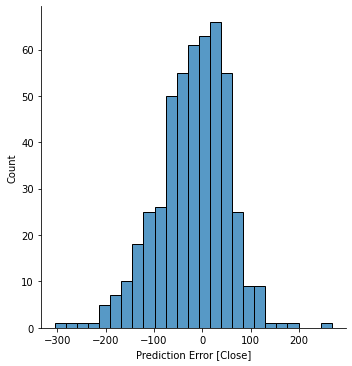

In [33]:
plotErrorHist(inversed_dfs['Model-12'])

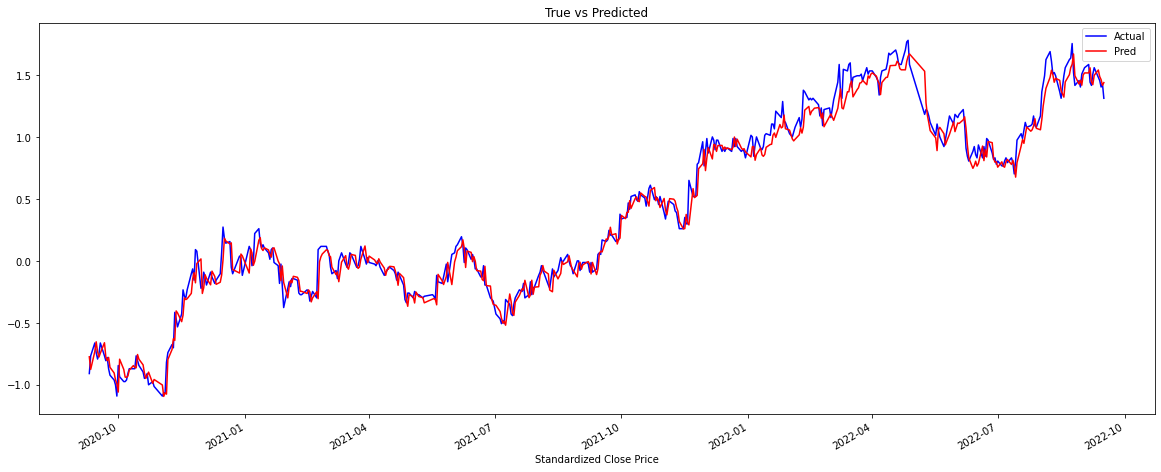

In [34]:
plot_pred_act(predictions_dfs['Model-12'])

## Save the best model

In [35]:
import keras

In [36]:
models['Model-12'][0].save('./models/tlkm.h5')

In [37]:
loadedModel = keras.models.load_model('./models/tlkm.h5')

In [38]:
loadedModel.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 1, 100)            47600     
                                                                 
 dropout_22 (Dropout)        (None, 1, 100)            0         
                                                                 
 lstm_23 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_23 (Dropout)        (None, 100)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 101       
                                                                 
Total params: 128,101
Trainable params: 128,101
Non-trainable params: 0
_________________________________________________________________


In [39]:
yhat = loadedModel.predict(X_test)

16/16 [==============================] - 1s 2ms/step
